# Preparation

Make sure to download the corresponding medical ontologies to build the term dictionaries. For each, look for the 2017 version.
 - Treatments: [OPS](https://www.bfarm.de/DE/Kodiersysteme/Services/Downloads/_node.html).
 - Medications: [ATC](https://www.wido.de/publikationen-produkte/arzneimittel-klassifikation/).
 - Diagnosis: [ICD10GM](https://www.bfarm.de/DE/Kodiersysteme/Services/Downloads/_node.html). 
 
In the config file for BRONCO `../conf/bronco.yaml`, modify the paths so they point the extracted folders. We assume they are located in `xmen/temp`. Otherwise, change the path here and correct accordingly the terminal commands below:

In [1]:
base_path = "../temp"

We can already use xMEN to prepare the term dictionaries. <u>This step only has to be performed the first time. </u> 

In your terminal, navigate to the xMEN root folder and run:
 - `xmen dict conf/bronco.yaml --code dicts/atc2017_de.py --output temp/ --key atc`
 - `xmen dict conf/bronco.yaml --code dicts/ops2017.py --output temp/ --key ops`
 - `xmen dict conf/bronco.yaml --code dicts/icd10gm2017.py --output temp/ --key icd10gm`
 
Now use such dictionaries to build the indexes. For this example, we will use only SapBERT indexes and leave aside N-Gram:
 - `xmen index conf/bronco.yaml --dict temp/atc.jsonl --output temp/atc_index --sapbert`
 - `xmen index conf/bronco.yaml --dict temp/ops.jsonl --output temp/ops_index --sapbert`
 - `xmen index conf/bronco.yaml --dict temp/icd10gm.jsonl --output temp/icd10gm_index --sapbert`
 
Now we can load the BRONCO150 dataset using BigBIO:

In [2]:
import datasets

path_to_data = r"../../BRONCO150" # paste here the path to the local data

bronco = datasets.load_dataset(path = "bigbio/bronco", 
                               name = "bronco_bigbio_kb", 
                               data_dir=path_to_data)

bronco

Found cached dataset bronco (/dhc/home/ignacio.rodriguez/.cache/huggingface/datasets/bigbio___bronco/bronco_bigbio_kb-data_dir=..%2F..%2FBRONCO150/1.0.0/cab8fc4a62807688cb5b36df7a24eb7f364314862c4196f6ff2db3813f2fe68b)


  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'document_id', 'passages', 'entities', 'events', 'coreferences', 'relations'],
        num_rows: 5
    })
})

Finally, we have to choose the semantic class we want to work on and reestructure the dataset in 5 folds for cross-validation, as originally intended.

In [3]:
label = "MEDICATION" # Choose here TREATMENT, MEDICATION or DIAGNOSIS

In [4]:
label2dict = {
    "TREATMENT": "ops",
    "MEDICATION": "atc",
    "DIAGNOSIS": "icd10gm"
}

def filter_entities(bigbio_entities, valid_entities):
    filtered_entities = []
    for ent in bigbio_entities:
        if ent['type'] in valid_entities:
            filtered_entities.append(ent)
    return filtered_entities

ds = bronco.map(lambda row: {'entities': filter_entities(row['entities'], [label])})

Loading cached processed dataset at /dhc/home/ignacio.rodriguez/.cache/huggingface/datasets/bigbio___bronco/bronco_bigbio_kb-data_dir=..%2F..%2FBRONCO150/1.0.0/cab8fc4a62807688cb5b36df7a24eb7f364314862c4196f6ff2db3813f2fe68b/cache-55c726efdf31fa90.arrow


In [5]:
from datasets import DatasetDict

ground_truth = DatasetDict()
for k in range(5):
    ground_truth[f"k{k+1}"] = ds["train"].select([k])
    
ds = ground_truth
ds

DatasetDict({
    k1: Dataset({
        features: ['id', 'document_id', 'passages', 'entities', 'events', 'coreferences', 'relations'],
        num_rows: 1
    })
    k2: Dataset({
        features: ['id', 'document_id', 'passages', 'entities', 'events', 'coreferences', 'relations'],
        num_rows: 1
    })
    k3: Dataset({
        features: ['id', 'document_id', 'passages', 'entities', 'events', 'coreferences', 'relations'],
        num_rows: 1
    })
    k4: Dataset({
        features: ['id', 'document_id', 'passages', 'entities', 'events', 'coreferences', 'relations'],
        num_rows: 1
    })
    k5: Dataset({
        features: ['id', 'document_id', 'passages', 'entities', 'events', 'coreferences', 'relations'],
        num_rows: 1
    })
})

# Run Candidate Generator
We will use `SapBERTLinker`, which uses a Transformer model to retrieve candidates with dense embeddings.

In [6]:
from xmen.linkers import SapBERTLinker
from xmen.evaluation import evaluate_at_k

Your CPU supports instructions that this binary was not compiled to use: SSE3 SSE4.1 SSE4.2 AVX AVX2
For maximum performance, you can install NMSLIB from sources 
pip install --no-binary :all: nmslib


<u>This cell can be run just once. For subsequent runs you can load the result with the cell below this one.</u>

In [7]:
embedding_model_name = 'cambridgeltl/SapBERT-UMLS-2020AB-all-lang-from-XLMR'

SapBERTLinker.clear()
sapbert_linker = SapBERTLinker(
    model_name = embedding_model_name,
    index_base_path = f"{base_path}/{label2dict[label]}_index/index/sapbert",
    k = 1000
)

candidates = sapbert_linker.predict_batch(ds, batch_size=128)

# Save locally to avoid running it every time
candidates.save_to_disk(f"{base_path}/{label2dict[label]}_index/pred_sapbert")

[06/14/23 11:33:26] INFO     Loading hierarchical faiss index                                ]8;id=335948;file:///dhc/home/ignacio.rodriguez/xmen/xmen/linkers/sap_bert_linker.py\sap_bert_linker.py]8;;\:]8;id=290625;file:///dhc/home/ignacio.rodriguez/xmen/xmen/linkers/sap_bert_linker.py#143\143]8;;\

                    INFO     Loading index from                                                 ]8;id=203957;file:///dhc/home/ignacio.rodriguez/xmen/xmen/linkers/faiss_indexer.py\faiss_indexer.py]8;;\:]8;id=801370;file:///dhc/home/ignacio.rodriguez/xmen/xmen/linkers/faiss_indexer.py#64\64]8;;\
                             ../temp/atc_index/index/sapbert/embed_faiss_hier.pickle                               

                    INFO     Loaded index of type <class 'faiss.swigfaiss_avx2.IndexHNSWFlat'>  ]8;id=142352;file:///dhc/home/ignacio.rodriguez/xmen/xmen/linkers/faiss_indexer.py\faiss_indexer.py]8;;\:]8;id=588702;file:///dhc/home/ignacio.rodriguez/xmen/xmen/linkers/faiss_indexer.py#66\66]8;;\
                             and size 8044                                                                         

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

In [8]:
candidates = datasets.load_from_disk(f"{base_path}/{label2dict[label]}_index/pred_sapbert")

# Recall for different numbers of candidates (k)
_ = evaluate_at_k(ds['k5'], candidates['k5'])

Perf@1 0.45
Perf@2 0.490625
Perf@4 0.50625
Perf@8 0.53125
Perf@16 0.571875
Perf@32 0.58125
Perf@64 0.59375


# Train Cross-encoder
We use a cross-encoder to embed the mention with their context together with all potential candidates. This way, we can learn the best ranking of candidates from the training data.

In [9]:
from xmen.reranking.cross_encoder import CrossEncoderReranker, CrossEncoderTrainingArgs
from xmen.linkers.util import filter_and_apply_threshold
from xmen.kb import load_kb
from xmen.data.indexed_dataset import IndexedDatasetDict, IndexedDataset

<u>This cell can be run just once. For subsequent runs you can load the result with the cell below this one.</u>

In [10]:
K_RERANKING = 64
candidates = filter_and_apply_threshold(candidates, K_RERANKING, 0.0)
kb = load_kb(f"{base_path}/{label2dict[label]}.jsonl")

cross_enc_ds = CrossEncoderReranker.prepare_data(candidates, ds, kb)

# Save locally to avoid running it every time
cross_enc_ds.save_to_disk(f"{base_path}/{label2dict[label]}_index/cross_encoded_dataset")
cross_enc_ds

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Context length: 128


  0%|          | 0/325 [00:00<?, ?it/s]

  0%|          | 0/325 [00:00<?, ?it/s]

  0%|          | 0/325 [00:00<?, ?it/s]

  0%|          | 0/333 [00:00<?, ?it/s]

  0%|          | 0/333 [00:00<?, ?it/s]

  0%|          | 0/333 [00:00<?, ?it/s]

  0%|          | 0/338 [00:00<?, ?it/s]

  0%|          | 0/338 [00:00<?, ?it/s]

  0%|          | 0/338 [00:00<?, ?it/s]

  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

{'k1': [325 items],
 'k2': [333 items],
 'k3': [338 items],
 'k4': [314 items],
 'k5': [320 items]}

In [13]:
cross_enc_ds = IndexedDatasetDict.load_from_disk(f"{base_path}/{label2dict[label]}_index/cross_encoded_dataset")
cross_enc_ds

{'k1': [325 items],
 'k2': [333 items],
 'k5': [320 items],
 'k4': [314 items],
 'k3': [338 items]}

Now we set the training arguments, train-eval splits and fit the model. Depending on the number of epochs, the training can take several hours.

In [11]:
train_args = CrossEncoderTrainingArgs(
    num_train_epochs = 10,
    model_name = "SCAI-BIO/bio-gottbert-base",
    score_regularization=True,
)

rr = CrossEncoderReranker()
output_dir = f'{base_path}/{label2dict[label]}_index/cross_encoder_training/'

In [12]:
# Choose train and evaluation folds
train_folds = [
    "k1",
    "k2",
    "k3",
    "k4",
    #"k5",
]
train = []
train = sum([train + cross_enc_ds[k].dataset for k in train_folds],[])


val_fold = "k4"
val = cross_enc_ds[val_fold].dataset

test_fold = "k5"

<u>This cell can be run just once. For subsequent runs you can load the result with the cell below this one.</u> (Unless you changed something in the model/input data and you want to train a new one)

In [13]:
rr.fit(train_dataset = train,
       val_dataset = val,
       output_dir=output_dir,
       training_args=train_args)

model_name := SCAI-BIO/bio-gottbert-base
num_train_epochs := 10
fp16 := True
label_smoothing := False
score_regularization := True
train_layers := None
softmax_loss := True
random_seed := 42


Some weights of the model checkpoint at SCAI-BIO/bio-gottbert-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at SCAI-BIO/bio-gottbert-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.den

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1310 [00:00<?, ?it/s]

2023-06-14 11:39:33 - EntityLinkingEvaluator: Evaluating the model on eval dataset after epoch 0:
2023-06-14 11:39:44 - Accuracy: 0.5127388535031847
2023-06-14 11:39:44 - Accuracy @ 5: 0.5636942675159236
2023-06-14 11:39:44 - Accuracy @ 64: 0.5923566878980892
2023-06-14 11:39:44 - Baseline Accuracy: 0.4745222929936306
2023-06-14 11:39:44 - Save model to ../temp/atc_index/cross_encoder_training/


Iteration:   0%|          | 0/1310 [00:00<?, ?it/s]

2023-06-14 11:41:15 - EntityLinkingEvaluator: Evaluating the model on eval dataset after epoch 1:
2023-06-14 11:41:26 - Accuracy: 0.5254777070063694
2023-06-14 11:41:26 - Accuracy @ 5: 0.5700636942675159
2023-06-14 11:41:26 - Accuracy @ 64: 0.5923566878980892
2023-06-14 11:41:26 - Baseline Accuracy: 0.4745222929936306
2023-06-14 11:41:26 - Save model to ../temp/atc_index/cross_encoder_training/


Iteration:   0%|          | 0/1310 [00:00<?, ?it/s]

2023-06-14 11:42:57 - EntityLinkingEvaluator: Evaluating the model on eval dataset after epoch 2:
2023-06-14 11:43:09 - Accuracy: 0.5318471337579618
2023-06-14 11:43:09 - Accuracy @ 5: 0.5764331210191083
2023-06-14 11:43:09 - Accuracy @ 64: 0.5923566878980892
2023-06-14 11:43:09 - Baseline Accuracy: 0.4745222929936306
2023-06-14 11:43:09 - Save model to ../temp/atc_index/cross_encoder_training/


Iteration:   0%|          | 0/1310 [00:00<?, ?it/s]

2023-06-14 11:44:39 - EntityLinkingEvaluator: Evaluating the model on eval dataset after epoch 3:
2023-06-14 11:44:50 - Accuracy: 0.5382165605095541
2023-06-14 11:44:50 - Accuracy @ 5: 0.5764331210191083
2023-06-14 11:44:50 - Accuracy @ 64: 0.5923566878980892
2023-06-14 11:44:50 - Baseline Accuracy: 0.4745222929936306
2023-06-14 11:44:50 - Save model to ../temp/atc_index/cross_encoder_training/


Iteration:   0%|          | 0/1310 [00:00<?, ?it/s]

2023-06-14 11:46:21 - EntityLinkingEvaluator: Evaluating the model on eval dataset after epoch 4:
2023-06-14 11:46:32 - Accuracy: 0.5414012738853503
2023-06-14 11:46:32 - Accuracy @ 5: 0.5796178343949044
2023-06-14 11:46:32 - Accuracy @ 64: 0.5923566878980892
2023-06-14 11:46:32 - Baseline Accuracy: 0.4745222929936306
2023-06-14 11:46:32 - Save model to ../temp/atc_index/cross_encoder_training/


Iteration:   0%|          | 0/1310 [00:00<?, ?it/s]

2023-06-14 11:48:02 - EntityLinkingEvaluator: Evaluating the model on eval dataset after epoch 5:
2023-06-14 11:48:14 - Accuracy: 0.5382165605095541
2023-06-14 11:48:14 - Accuracy @ 5: 0.5796178343949044
2023-06-14 11:48:14 - Accuracy @ 64: 0.5923566878980892
2023-06-14 11:48:14 - Baseline Accuracy: 0.4745222929936306


Iteration:   0%|          | 0/1310 [00:00<?, ?it/s]

2023-06-14 11:49:44 - EntityLinkingEvaluator: Evaluating the model on eval dataset after epoch 6:
2023-06-14 11:49:55 - Accuracy: 0.5414012738853503
2023-06-14 11:49:55 - Accuracy @ 5: 0.5732484076433121
2023-06-14 11:49:55 - Accuracy @ 64: 0.5923566878980892
2023-06-14 11:49:55 - Baseline Accuracy: 0.4745222929936306


Iteration:   0%|          | 0/1310 [00:00<?, ?it/s]

2023-06-14 11:51:24 - EntityLinkingEvaluator: Evaluating the model on eval dataset after epoch 7:
2023-06-14 11:51:36 - Accuracy: 0.5414012738853503
2023-06-14 11:51:36 - Accuracy @ 5: 0.5732484076433121
2023-06-14 11:51:36 - Accuracy @ 64: 0.5923566878980892
2023-06-14 11:51:36 - Baseline Accuracy: 0.4745222929936306


Iteration:   0%|          | 0/1310 [00:00<?, ?it/s]

2023-06-14 11:53:06 - EntityLinkingEvaluator: Evaluating the model on eval dataset after epoch 8:
2023-06-14 11:53:17 - Accuracy: 0.5477707006369427
2023-06-14 11:53:17 - Accuracy @ 5: 0.5764331210191083
2023-06-14 11:53:17 - Accuracy @ 64: 0.5923566878980892
2023-06-14 11:53:17 - Baseline Accuracy: 0.4745222929936306
2023-06-14 11:53:17 - Save model to ../temp/atc_index/cross_encoder_training/


Iteration:   0%|          | 0/1310 [00:00<?, ?it/s]

2023-06-14 11:54:48 - EntityLinkingEvaluator: Evaluating the model on eval dataset after epoch 9:
2023-06-14 11:54:59 - Accuracy: 0.5414012738853503
2023-06-14 11:54:59 - Accuracy @ 5: 0.5732484076433121
2023-06-14 11:54:59 - Accuracy @ 64: 0.5923566878980892
2023-06-14 11:54:59 - Baseline Accuracy: 0.4745222929936306


# Evaluate Cross-encoder
Now we can take our trained model and test it on data outside of training. Using the `xmen.evaluation` module, we gain insights into different error types.

In [23]:
rr = CrossEncoderReranker.load(output_dir, device=0)

2023-06-13 20:01:59 - Use pytorch device: cuda


In [14]:
cross_enc_pred_val = rr.rerank_batch(candidates[val_fold], cross_enc_ds[val_fold])
_ = evaluate_at_k(ds[val_fold], cross_enc_pred_val)

Batches:   0%|          | 0/314 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Perf@1 0.5414012738853503
Perf@2 0.5668789808917197
Perf@4 0.5700636942675159
Perf@8 0.5859872611464968
Perf@16 0.5859872611464968
Perf@32 0.5923566878980892
Perf@64 0.5923566878980892


In [15]:
cross_enc_pred_test = rr.rerank_batch(candidates[test_fold], cross_enc_ds[test_fold])
_ = evaluate_at_k(ds[test_fold], cross_enc_pred_test)

Batches:   0%|          | 0/320 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Perf@1 0.490625
Perf@2 0.5375
Perf@4 0.54375
Perf@8 0.571875
Perf@16 0.578125
Perf@32 0.5875
Perf@64 0.59375


In [16]:
from notebook_util import analyze
from xmen.evaluation import entity_linking_error_analysis

In [17]:
cg_kb = load_kb(f"{base_path}/{label2dict[label]}.jsonl")
error_cand = entity_linking_error_analysis(ds[test_fold], candidates[test_fold])
edf_cand, _ = analyze(error_cand, cg_kb, 'eval', None)

In [18]:
# False negative (not part of top 64)
fns_cand = edf_cand[edf_cand.pred_index == -1]
fns_cand_counts = fns_cand.error_type.value_counts() / len(edf_cand)
fns_cand_counts

error_type
WRONG_SEMANTIC_TYPE    0.321875
ABBREV                 0.075000
MISSING_CUI_GOLD       0.009375
Name: count, dtype: float64

In [19]:
# Ranking errors during candidate generation
misranked_cand = edf_cand[edf_cand.pred_index > 0]
misranked_cand_counts = misranked_cand.error_type.value_counts() / len(edf_cand)
misranked_cand_counts

error_type
WRONG_SEMANTIC_TYPE    0.12500
ABBREV                 0.01875
Name: count, dtype: float64

In [20]:
# Ranking errors after reranking
error_rr = entity_linking_error_analysis(ds[val_fold], cross_enc_pred_val)
edf_rr, _ = analyze(error_rr, cg_kb, 'eval', None)

misranked_rr = edf_rr[edf_rr.pred_index > 0]
misranked_rr_counts = misranked_rr.error_type.value_counts() / len(edf_rr)
misranked_rr_counts

error_type
WRONG_SEMANTIC_TYPE    0.035032
ABBREV                 0.015924
Name: count, dtype: float64

In [21]:
print('Recall@1', (edf_rr.pred_index == 0).sum() / len(edf_rr))
print('Recall@64', (edf_rr.pred_index >= 0).sum() / len(edf_rr))

Recall@1 0.5414012738853503
Recall@64 0.5923566878980892


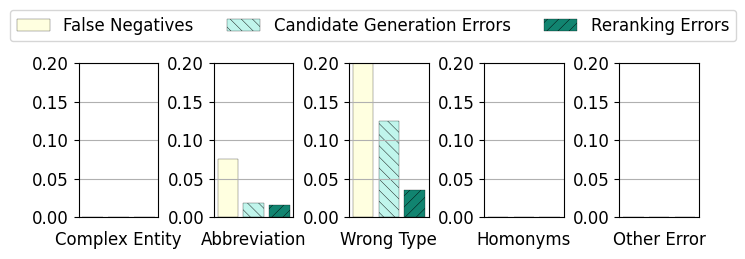

In [22]:
import matplotlib
from matplotlib import pyplot as plt

error_types = ['Complex Entity', 'Abbreviation', 'Wrong Type', 'Homonyms', 'Other Error']
keys = ['COMPLEX_ENTITY', 'ABBREV', 'WRONG_SEMANTIC_TYPE', 'SAME_SYNONYMS', 'UNKNOWN_ERROR']
counts = [fns_cand_counts, misranked_cand_counts, misranked_rr_counts]
count_names = ['False Negatives', 'Candidate Generation Errors', 'Reranking Errors']

hatches = ['', '\\\\\\', '///']
colors = ['lightyellow', '#C0F5EC', '#118470']

matplotlib.rcParams['hatch.linewidth'] = 0.3 
matplotlib.rcParams.update({'font.size': 12})

fig, axs = plt.subplots(1, len(keys), figsize=(8, 2))
for i, (key, error) in enumerate(zip(keys, error_types)):
    for j, bar in enumerate(axs[i].bar(x=count_names, height=[c.get(key, 0.0) for c in counts], color=colors, edgecolor = 'black', linewidth=0.2)):
        bar.set_hatch(hatches[j])
    axs[i].grid(axis='y')
    axs[i].set_ylim([0.0, 0.2])
    axs[i].set_xlabel(error, labelpad=10)
    axs[i].get_xaxis().set_ticks([])
handles = [plt.Rectangle((0,0),1,1, facecolor=color, linewidth=0.2, edgecolor='black', hatch=h) for color, h in zip(colors, hatches)]
plt.legend(handles, count_names, loc='upper center', bbox_to_anchor=(-3.1, 1.4, 0, 0), ncol=len(counts))

plt.subplots_adjust(wspace=0.7)